National-Scale CAD Crime Classification Using Zero-Shot Embedding Prototypes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.express as px
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import ahocorasick
import warnings
warnings.filterwarnings("ignore")
pio.renderers.default = "notebook"  # or "notebook", "colab", "browser", etc.

# Load your dataset
df_nlp = pd.read_parquet("./data/opd_nlp_dataset.parquet")
df_nlp

c:\Users\manuz\Desktop\Adm\Projects\PoliceDataTopicModeling\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,state,city,incident_date,crime_description,source_file,table_type
0,New York,Albany,2021-09-11,OPEN WINDOW/DOOR,Albany_New York_CALLS_FOR_SERVICE_2021-2022.pa...,CALLS FOR SERVICE
1,New York,Albany,2021-09-11,ASSAULT,Albany_New York_CALLS_FOR_SERVICE_2021-2022.pa...,CALLS FOR SERVICE
2,New York,Albany,2021-09-11,TRAFFIC STOP,Albany_New York_CALLS_FOR_SERVICE_2021-2022.pa...,CALLS FOR SERVICE
3,New York,Albany,2021-09-11,PERSON WITH A WEAPON,Albany_New York_CALLS_FOR_SERVICE_2021-2022.pa...,CALLS FOR SERVICE
4,New York,Albany,2021-09-11,EMS CALL,Albany_New York_CALLS_FOR_SERVICE_2021-2022.pa...,CALLS FOR SERVICE
...,...,...,...,...,...,...
74977748,California,Stockton,2025-04-08,MISCELLANEOUS,Stockton_California_CALLS_FOR_SERVICE_2019-202...,CALLS FOR SERVICE
74977749,California,Stockton,2025-04-08,CELL 911 HANG UP,Stockton_California_CALLS_FOR_SERVICE_2019-202...,CALLS FOR SERVICE
74977750,California,Stockton,2025-04-08,FIRE,Stockton_California_CALLS_FOR_SERVICE_2019-202...,CALLS FOR SERVICE
74977751,California,Stockton,2025-04-08,AMBULANCE REQ,Stockton_California_CALLS_FOR_SERVICE_2019-202...,CALLS FOR SERVICE


In [2]:
def build_automaton(patterns):
    """Build Aho–Corasick automaton mapping keyword → category."""
    A = ahocorasick.Automaton()
    for category, pattern_str in patterns.items():
        # Split on | and clean up each keyword
        keywords = [k.strip().lower() for k in pattern_str.split("|")]
        for kw in keywords:
            if kw:  # Skip empty strings
                # Store tuple of (keyword, category) to handle overlaps
                A.add_word(kw, (kw, category))
    A.make_automaton()
    return A

def bootstrap_label(texts):
    texts = pd.Series(texts, dtype="string").str.lower().fillna("")
    
    patterns = {
        "Theft / Larceny":                 "theft|stole|larceny|shoplift|stolen|purse|wallet",
        "Burglary / Breaking & Entering":  "burglary|break in|b&e|forced entry|burglar",
        "Assault / Battery":               "assault|battery|fight|hit|beat|punch|attack",
        "Robbery":                         "robbery|mugging|armed robbery|hold up|carjack",
        "Vandalism / Property Damage":     "vandalism|graffiti|damage|broken window|smashed|fire",
        "Drug / Narcotics Violation":      "drug|narcotic|meth|cocaine|heroin|marijuana|weed",
        "Weapons Violation":               "gun|weapon|firearm|shot|shooting|knife",
        "Traffic / DUI":                   "dui|drunk driving|owi|hit and run|reckless|traffic",
        "Disorderly Conduct / Disturbance":"disturbance|disorderly|noise complaint|loud music|415",
        "Trespassing":                     "trespass|loitering",
        "Fraud / Forgery":                 "fraud|scam|forgery|identity theft",
        "Sex Offense":                     "rape|sexual assault|indecent|prostitution",
        "Homicide":                        "homicide|murder|shooting|dead body",
        "Missing Person / Runaway":        "missing person|runaway",
        "Suspicious Activity / Person":    "suspicious|prowler|watching house",
        "Mental Health / Welfare Check":   "mental|suicidal|welfare check|5150|edp",
        "Domestic Dispute":                "domestic|family dispute|boyfriend|girlfriend|spouse",
        "Juvenile / Youth Issue":          "juvenile|truancy|curfew",
        "Animal Complaint":                "dog|bite|stray animal|barking",
    }
    
    # Build automaton once
    A = build_automaton(patterns)
    
    def label_one(text):
        for end_index, (keyword, category) in A.iter(text):
            return category  # First match wins
        return "Other / Unknown"
    
    return texts.apply(label_one).values

# embedder = SentenceTransformer("all-MiniLM-L6-v2")
embedder = SentenceTransformer("paraphrase-MiniLM-L3-v2") # Best fast embedder (2025 gold standard for police text)
# embedder = SentenceTransformer("sentence-transformers/all-distilroberta-v1")
# embedder = SentenceTransformer("sentence-transformers/paraphrase-TinyBERT-L6-v2")
embedder.max_seq_length = 64

# ——— TRAIN & PREDICT SEPARATELY FOR EACH TABLE TYPE ———
df_nlp['crime_category'] = "pending"
# df_nlp['label'] = ""

# 20 clean categories ("few-shot" prompt)
CATEGORIES= [
    "Theft from Vehicle",
    "Stolen Vehicle",
    "Petty Theft / Shoplifting",
    "Residential Burglary",
    "Battery / Domestic Violence",
    "Simple Assault / Fight",
    "Traffic Stop / Citation",
    "DUI / Drunk Driving",
    "Shots Fired / Person with Gun",               # ← weapons only
    "Suspicious Person / Prowler",                 # ← loitering, weird behavior
    "911 Hangup / Open Line",                      # ← NEW: separate & correct
    "Disturbance / Loud Party / Neighbor Dispute",
    "Welfare Check / Mental Health Crisis",        # ← 911 hangups often go here too
    "Trespass / Unwanted Person",
    "Vandalism / Property Damage",
    "Narcotics / Drug Possession",
    "Prostitution / Vice",
    "Robbery / Street Robbery",
    "Alarm Call / False Alarm",
    "Officer-Initiated / On-View Activity",
    "Non-Emergency / Information Call",
    "Fire / Medical / Ambulance Request",
    "Missing Person / Runaway",
    "Juvenile / Truancy / Curfew",
    "Fraud / Identity Theft / Scam",
    "Threats / Harassment / Stalking",
    "Other / Unknown / Administrative"
]

In [3]:
for table_type in ["CALLS FOR SERVICE", "INCIDENTS"]:
    print(f"\n{'='*20} {table_type} {'='*20}")
    mask = df_nlp['table_type'] == table_type
    subset = df_nlp.loc[mask]
    print(f"   → {len(subset):,} rows")

    # 1. Create embeddings - this can take several minutes
    print("Computing embeddings...")
    unique_desc, inverse = np.unique(
        subset['crime_description'].astype(str).values, 
        return_inverse=True
    )
    embeddings = embedder.encode(
        unique_desc.tolist(),
        batch_size=8192,
        show_progress_bar=True,
        normalize_embeddings=True,
        convert_to_numpy=True,
        device='cpu',
    )

    # 2. Few-shot "training" using category names as prototypes
    print("   → Creating category prototypes (few-shot style)...")
    proto_emb = embedder.encode(CATEGORIES, normalize_embeddings=True)

    # 3. Nearest prototype = prediction (this is zero-shot classification)
    print("   → zero-shot classification...")
    sim = cosine_similarity(embeddings, proto_emb)
    predictions_idx = sim.argmax(axis=1)
    predictions = [CATEGORIES[i] for i in predictions_idx]
    
    # Map back to full data
    full_predictions = np.array(predictions)[inverse]
    df_nlp.loc[mask, 'crime_category'] = full_predictions

df_nlp.to_parquet("./data/opd_nlp_dataset_fitted.parquet", compression="zstd")
df_nlp


==================== CALLS FOR SERVICE ====================
   → 51,587,968 rows
Computing embeddings...


Batches: 100%|██████████| 3/3 [00:24<00:00,  8.29s/it]


   → Creating category prototypes (few-shot style)...
   → zero-shot classification...

==================== INCIDENTS ====================
   → 23,389,785 rows
Computing embeddings...


Batches: 100%|██████████| 2/2 [00:22<00:00, 11.50s/it]


   → Creating category prototypes (few-shot style)...
   → zero-shot classification...


,state,city,incident_date,crime_description,source_file,table_type,crime_category
0,New York,Albany,2021-09-11,OPEN WINDOW/DOOR,Albany_New York_CALLS_FOR_SERVICE_2021-2022.pa...,CALLS FOR SERVICE,911 Hangup / Open Line
1,New York,Albany,2021-09-11,ASSAULT,Albany_New York_CALLS_FOR_SERVICE_2021-2022.pa...,CALLS FOR SERVICE,Simple Assault / Fight
2,New York,Albany,2021-09-11,TRAFFIC STOP,Albany_New York_CALLS_FOR_SERVICE_2021-2022.pa...,CALLS FOR SERVICE,Traffic Stop / Citation
3,New York,Albany,2021-09-11,PERSON WITH A WEAPON,Albany_New York_CALLS_FOR_SERVICE_2021-2022.pa...,CALLS FOR SERVICE,Shots Fired / Person with Gun
4,New York,Albany,2021-09-11,EMS CALL,Albany_New York_CALLS_FOR_SERVICE_2021-2022.pa...,CALLS FOR SERVICE,Fire / Medical / Ambulance Request
...,...,...,...,...,...,...,...
74977748,California,Stockton,2025-04-08,MISCELLANEOUS,Stockton_California_CALLS_FOR_SERVICE_2019-202...,CALLS FOR SERVICE,Other / Unknown / Administrative
74977749,California,Stockton,2025-04-08,CELL 911 HANG UP,Stockton_California_CALLS_FOR_SERVICE_2019-202...,CALLS FOR SERVICE,911 Hangup / Open Line
74977750,California,Stockton,2025-04-08,FIRE,Stockton_California_CALLS_FOR_SERVICE_2019-202...,CALLS FOR SERVICE,Fire / Medical / Ambulance Request
74977751,California,Stockton,2025-04-08,AMBULANCE REQ,Stockton_California_CALLS_FOR_SERVICE_2019-202...,CALLS FOR SERVICE,Fire / Medical / Ambulance Request


In [4]:
# POST-CLASSIFICATION SANITY CHECK — THIS IS PURE GOLD
print("="*80)
print("SANITY CHECK: What does each crime category actually contain?")
print("="*80)

def analyze_category(cat):
    subset = df_nlp[df_nlp['crime_category'] == cat]
    total = len(subset)
    if total == 0:
        return
    
    print(f"\n→ {cat}")
    print(f"   Total records: {total:,} ({total/len(df_nlp):.1%} of all data)")
    
    # Top 15 most common descriptions
    top_desc = subset['crime_description'].value_counts().head(15)
    print("   Top real descriptions:")
    for desc, count in top_desc.items():
        pct = count / total * 100
        print(f"     • {desc:45} → {count:9,} ({pct:5.1f}%)")

# Run for all categories, sorted by size
categories_by_size = df_nlp['crime_category'].value_counts().index

for cat in categories_by_size:
    analyze_category(cat)

SANITY CHECK: What does each crime category actually contain?

→ 911 Hangup / Open Line
   Total records: 11,275,306 (15.0% of all data)
   Top real descriptions:
     • 911                                           → 5,018,737 ( 44.5%)
     • TELEPHONE OTHER, NOT 911                      → 2,192,387 ( 19.4%)
     • CELL 911 HANG UP                              → 1,768,946 ( 15.7%)
     • CODE 6                                        → 1,307,242 ( 11.6%)
     • 911 HANG UP                                   →   159,681 (  1.4%)
     • STATION RUN                                   →   157,499 (  1.4%)
     • 906 CODE 30 RINGER                            →    81,914 (  0.7%)
     • 911 HANG UP/DROP OFF                          →    78,466 (  0.7%)
     • CELL 911 UNKNOWN                              →    61,419 (  0.5%)
     • 911 DISCONNECT | NO POLICE ACTION             →    51,471 (  0.5%)
     • 911 HANG UP | P PATROL INFORMATION            →    49,808 (  0.4%)
     • 904 AMB         

In [5]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# Interactive sanity dashboard
summary = []
for cat in df_nlp['crime_category'].unique():
    subset = df_nlp[df_nlp['crime_category'] == cat]
    top3 = subset['crime_description'].value_counts().head(3)
    summary.append({
        'crime_category': cat,
        'total_records': len(subset),
        'top_description_1': top3.index[0] if len(top3)>0 else "",
        'count_1': top3.iloc[0] if len(top3)>0 else 0,
        'top_description_2': top3.index[1] if len(top3)>1 else "",
        'count_2': top3.iloc[1] if len(top3)>1 else 0,
        'top_description_3': top3.index[2] if len(top3)>2 else "",
        'count_3': top3.iloc[2] if len(top3)>2 else 0,
    })

summary_df = pd.DataFrame(summary).sort_values('total_records', ascending=False)
summary_df['% of total'] = (summary_df['total_records'] / len(df_nlp) * 100).round(2)

# Show as beautiful table
summary_df.style.background_gradient(cmap='Blues').format({
    'total_records': '{:,}',
    'count_1': '{:,}', 'count_2': '{:,}', 'count_3': '{:,}'
})

,crime_category,total_records,top_description_1,count_1,top_description_2,count_2,top_description_3,count_3,% of total
6,Suspicious Activity / Person,"10,545,085",Dispatched Incident,"3,185,184",ONVIEW,"3,000,260",Officer-Initiated Incident,"1,198,423",14.060000
1,Assault / Battery,"9,372,151","TELEPHONE OTHER, NOT 911","2,192,387",CELL 911 HANG UP,"1,768,946",BATTERY | DOMESTIC BATTERY SIMPLE,"660,047",12.500000
16,Theft / Larceny,"9,289,448",FIRE,"706,665",MISCELLANEOUS,"695,802",THEFT | $500 AND UNDER,"678,025",12.390000
2,Traffic / DUI,"7,121,948",AMBULANCE REQ,"1,549,692",TRAFFIC STOP,"883,047",TRAFFIC STOP | CIT,"323,062",9.500000
4,Homicide,"5,576,106",911,"5,018,737",EMOTIONALLY DIST,"118,132",CRIME PREVENTION,"57,948",7.440000
12,Other / Unknown,"5,180,696",unknown,"2,956,633",REPORTS,"533,634",ALL OTHER | All Other Offenses,"189,758",6.910000
14,Trespassing,"3,713,139",CODE 6,"1,307,242",PASSING CALL,"410,126",TRESPASSING,"392,856",4.950000
3,Weapons Violation,"3,346,412",PASSING CALL | HAN,"822,080",OFF DUTY POLICE DETAILS,"195,799",OTHER OFFENSE | TELEPHONE THREAT,"158,826",4.460000
7,Disorderly Conduct / Disturbance,"3,054,554",DISTURBANCE,"391,593",ADVISED INCIDENT,"248,140",FAMILY DISTURBANCE,"220,856",4.070000
0,Burglary / Breaking & Entering,"2,853,499",BURGLARY | FORCIBLE ENTRY,"294,510",BURGLARY OF VEHICLE,"265,706",BURGLARY,"258,531",3.810000


In [ ]:
# =============================================================================
# POST-ANALYSIS: Beautiful Aggregates & Visualizations (2025 style)
# =============================================================================


# Make plots look professional
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
px.defaults.width = 1000
px.defaults.height = 600

print(f"Dataset: {len(df_nlp):,} rows | {df_nlp['city'].nunique()} cities | {df_nlp['state'].nunique()} states")

Dataset: 74,977,753 rows | 22 cities | 16 states


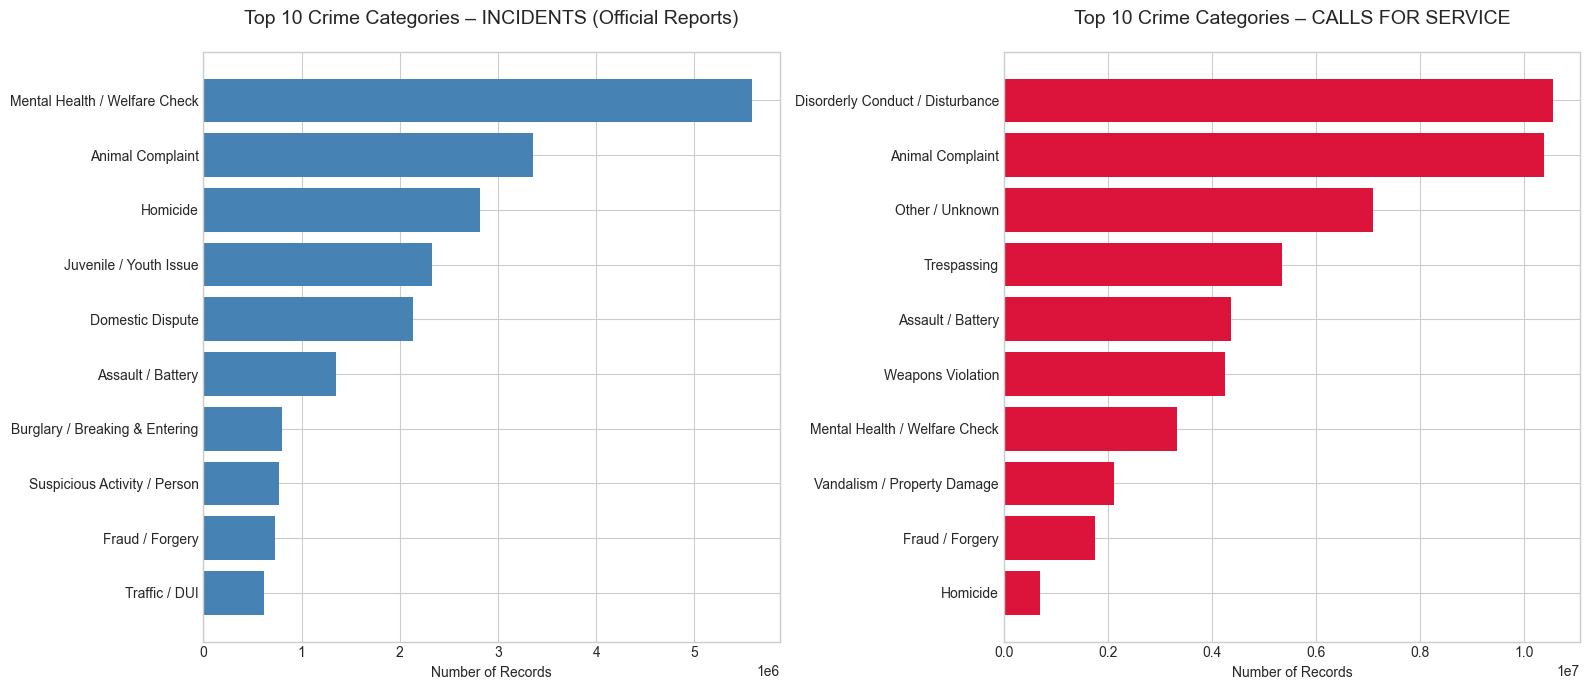

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# INCIDENTS
top_inc = df_nlp[df_nlp['table_type']=='INCIDENTS']['crime_category'].value_counts().head(10)
ax1.barh(top_inc.index[::-1], top_inc.values[::-1], color='steelblue')
ax1.set_title("Top 10 Crime Categories – INCIDENTS (Official Reports)", fontsize=14, pad=20)
ax1.set_xlabel("Number of Records")

# CALLS FOR SERVICE
top_call = df_nlp[df_nlp['table_type']=='CALLS FOR SERVICE']['crime_category'].value_counts().head(10)
ax2.barh(top_call.index[::-1], top_call.values[::-1], color='crimson')
ax2.set_title("Top 10 Crime Categories – CALLS FOR SERVICE", fontsize=14, pad=20)
ax2.set_xlabel("Number of Records")

plt.tight_layout()
plt.show()

In [ ]:
df = df_nlp.copy()
df = df[(df['incident_date']>='2010-01-01') & (df['incident_date']<='2025-12-31')]
monthly = (df
           .assign(month = df['incident_date'].dt.to_period('M').astype(str))
           .groupby(['month', 'table_type', 'crime_category'])
           .size()
           .reset_index(name='count')
           .sort_values('month'))

fig = px.area(monthly, 
              x='month', y='count', color='crime_category',
              facet_col='table_type',
              title="Crime Category Trends Over Time (Calls vs Incidents)",
              height=600)
fig.update_xaxes(tickangle=45)
fig.show()

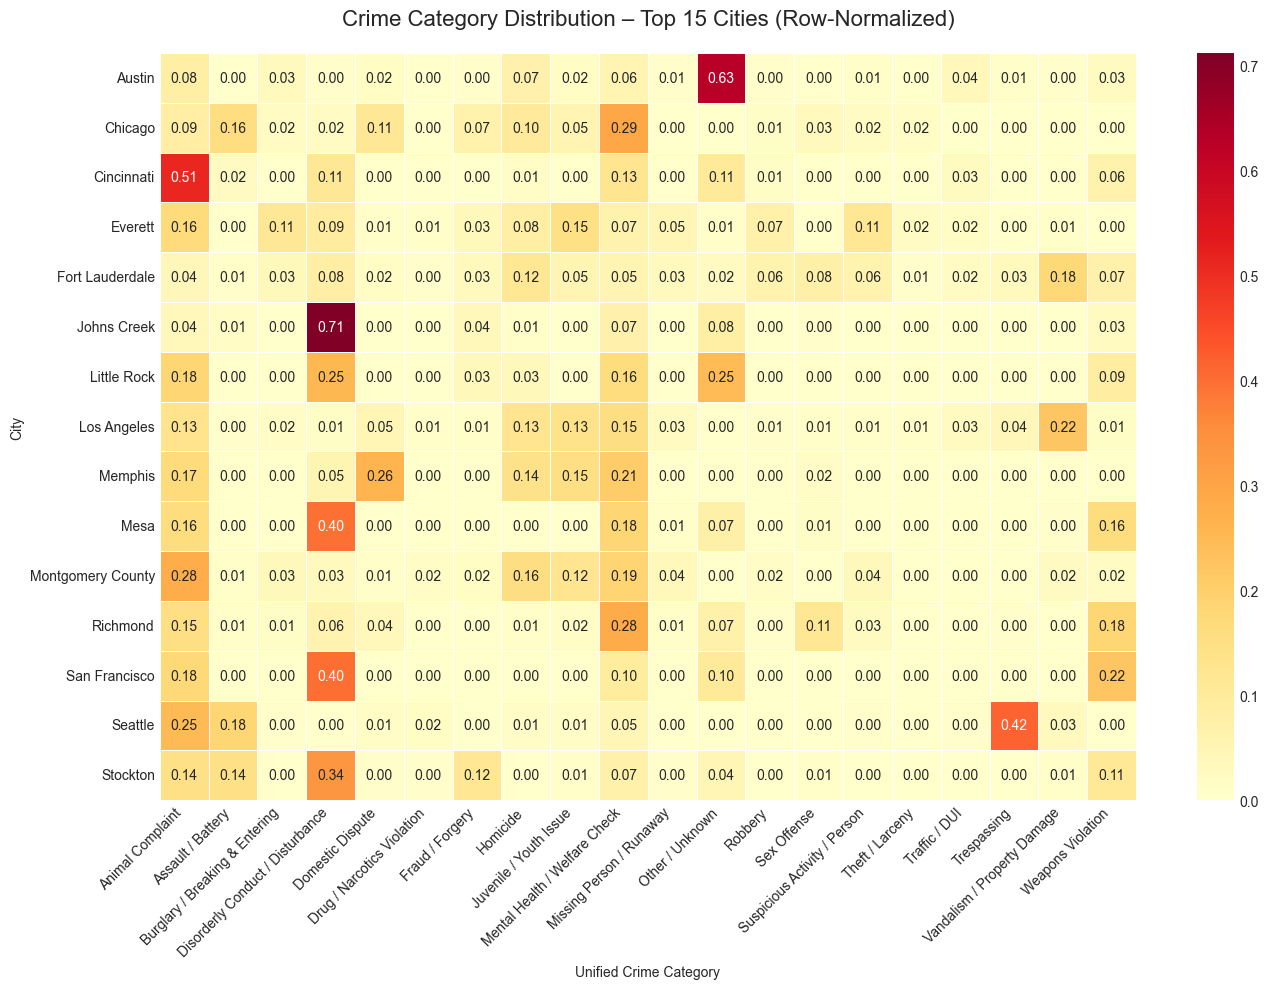

In [ ]:
top_cities = df_nlp['city'].value_counts().head(15).index

heat = (df_nlp[df_nlp['city'].isin(top_cities)]
        .groupby(['city', 'crime_category'])
        .size()
        .unstack(fill_value=0))

# Normalize per city (so Chicago doesn't dominate everything)
heat_norm = heat.div(heat.sum(axis=1), axis=0)

plt.figure(figsize=(14, 10))
sns.heatmap(heat_norm, cmap="YlOrRd", linewidths=.5, annot=True, fmt=".2f")
plt.title("Crime Category Distribution – Top 15 Cities (Row-Normalized)", fontsize=16, pad=20)
plt.ylabel("City")
plt.xlabel("Unified Crime Category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

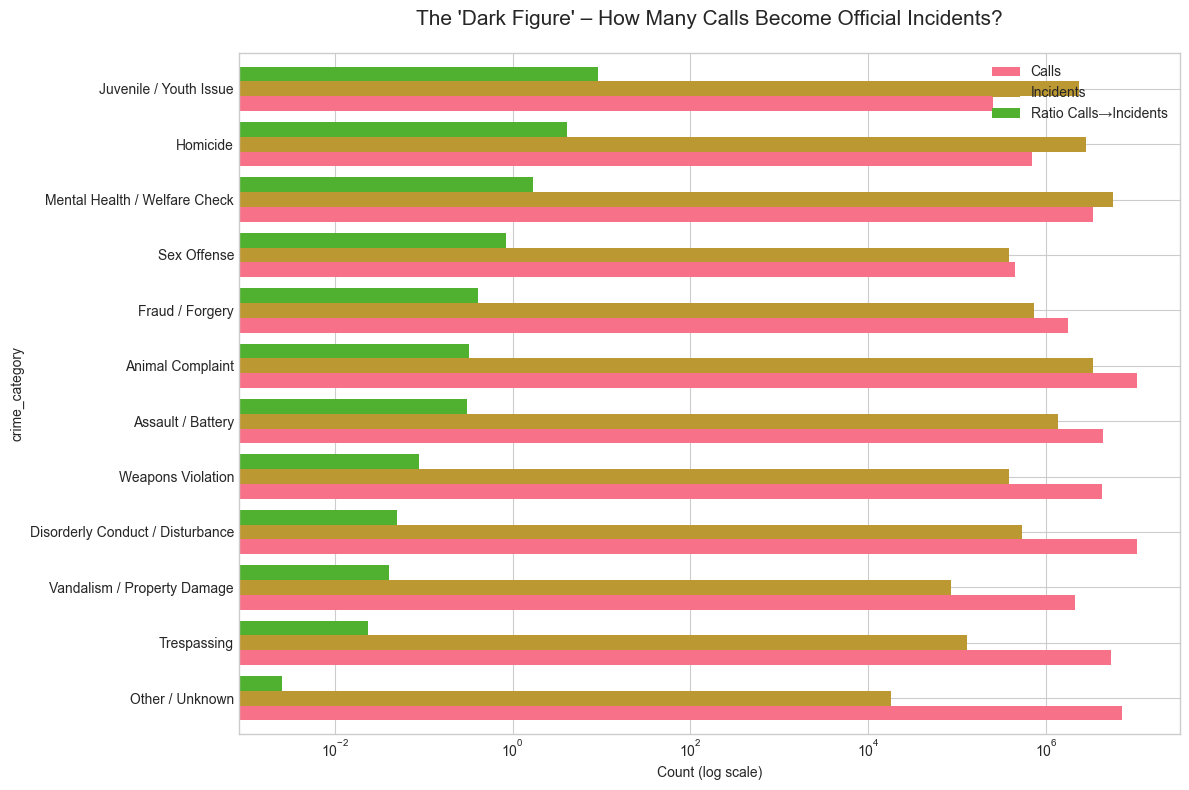

Most under-reported (calls >> incidents):
                                     Calls  Incidents  Ratio Calls→Incidents
crime_category                                                              
Other / Unknown                    7107263      18009               0.002534
Trespassing                        5351487     128254               0.023966
Vandalism / Property Damage        2114196      86109               0.040729
Disorderly Conduct / Disturbance  10553569     532194               0.050428
Weapons Violation                  4255828     380069               0.089306


In [ ]:
call_only = df_nlp[df_nlp['table_type'] == 'CALLS FOR SERVICE']
inc_only  = df_nlp[df_nlp['table_type'] == 'INCIDENTS']

dark_figure = (call_only['crime_category'].value_counts().head(12)
               .to_frame(name="Calls")
               .join(inc_only['crime_category'].value_counts().rename("Incidents"), how='left')
               .fillna(0))

dark_figure['Ratio Calls→Incidents'] = dark_figure['Incidents'] / dark_figure['Calls']
dark_figure = dark_figure.sort_values("Ratio Calls→Incidents")

dark_figure.plot(kind='barh', figsize=(12, 8), width=0.8)
plt.title("The 'Dark Figure' – How Many Calls Become Official Incidents?", pad=20, fontsize=15)
plt.xlabel("Count (log scale)")
plt.xscale('log')
plt.tight_layout()
plt.show()

print("Most under-reported (calls >> incidents):")
print(dark_figure.head(5))

In [ ]:
treemap_data = (df_nlp
                .groupby(['state', 'city', 'crime_category'])
                .size()
                .reset_index(name='count'))

fig = px.treemap(treemap_data,
                 path=['state', 'city', 'crime_category'],
                 values='count',
                 color='count',
                 color_continuous_scale='Reds',
                 title="National Crime Category Map – State → City → Category")
fig.show()